In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
# 디렉토리 설정
unlabeled_data_dir = r"./injectionmoding_dataset/injectionmoding_dataset_unlabeled.csv"
unlabeled_df = pd.read_csv(unlabeled_data_dir)

labeled_data_dir = r"./injectionmoding_dataset/경진대회용 사출성형기 데이터셋_labeled.csv"
labeled_df = pd.read_csv(labeled_data_dir)

In [3]:
# 디스플레이 옵션 설정
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.unicode.east_asian_width', True)

In [4]:
def useless_data_drop(dataframe):
    # 중복 데이터 제거
    dataframe = dataframe.drop_duplicates()
    # 1차 분석 후 불필요 데이터 제거
    dataframe.drop("_id", axis=1, inplace=True)
    dataframe.drop("PART_FACT_PLAN_DATE", axis=1, inplace=True)
    # 분석모델에 쓸모 없는 데이터 제거
    for column, value in dataframe.std().iteritems():
        if value == 0:
            dataframe.drop(f"{column}", axis=1, inplace=True)
    # Datetime으로 변경
    dataframe["TimeStamp"] = pd.to_datetime(dataframe['TimeStamp'], yearfirst=True)
    return dataframe

In [5]:
# 필요없는 데이터 제거
unlabeled_df = useless_data_drop(unlabeled_df)
unlabeled_df.drop("Unnamed: 0", axis=1, inplace=True)


labeled_df = useless_data_drop(labeled_df)

C:\Users\break\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [6]:
# 장비, 제품 별 분류 함수
def div_pa_eq(dataframe, part_name, equip_name):
    part_name_filter = dataframe["PART_NAME"].str.contains(part_name)
    equip_name_filter = dataframe["EQUIP_NAME"].str.contains(equip_name)

    return dataframe[part_name_filter & equip_name_filter]

In [7]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
ERR_filter = unlabeled_df["ERR_FACT_QTY"] <= 0  # 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
SOP_filter = unlabeled_df["Switch_Over_Position"] == 0  # Switch_Over_Position 0인지 아닌지에 따라 공정이 달라지는듯

CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter & ERR_filter & SOP_filter]

In [8]:
# 이상치 측정 함수
def outlier(x):
    Q1 = x.quantile(1/4)
    Q3 = x.quantile(3/4)
    IQR = Q3 - Q1
    LL = Q1 - (1.5*IQR)
    UU = Q3 + (1.5*IQR)
    outlier = (x < LL) | (x > UU)
    return outlier

# unlabeled데이터 분석 후 사용 안하는 데이터 제거

In [9]:
# 종속 변수 제거
CN7_650T_df["Packing_Time"] = CN7_650T_df["Injection_Time"] - CN7_650T_df["Filling_Time"]
CN7_650T_df["Avg_Mold_Temperature"] = (CN7_650T_df["Mold_Temperature_3"] + CN7_650T_df["Mold_Temperature_4"])/2
unlabeled_CN7_650T_train = CN7_650T_df.drop(["Barrel_Temperature_7", "PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "ERR_FACT_QTY", "TimeStamp","Injection_Time", "Switch_Over_Position", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)
# unlabeled_CN7_650T_train = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "ERR_FACT_QTY", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)

unlabeled_CN7_650T_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135 entries, 500632 to 775136
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              2135 non-null   float64
 1   Plasticizing_Time         2135 non-null   float64
 2   Cycle_Time                2135 non-null   float64
 3   Clamp_Close_Time          2135 non-null   float64
 4   Cushion_Position          2135 non-null   float64
 5   Plasticizing_Position     2135 non-null   float64
 6   Clamp_Open_Position       2135 non-null   float64
 7   Max_Injection_Speed       2135 non-null   float64
 8   Max_Screw_RPM             2135 non-null   float64
 9   Average_Screw_RPM         2135 non-null   float64
 10  Max_Injection_Pressure    2135 non-null   float64
 11  Max_Switch_Over_Pressure  2135 non-null   float64
 12  Max_Back_Pressure         2135 non-null   float64
 13  Average_Back_Pressure     2135 non-null   float64
 14  B

C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# labeled데이터 분석 후 사용 안하는 데이터 제거

In [10]:
# CN7_우진650톤 데이터 추출
CN7_filter = labeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = labeled_df["EQUIP_NAME"].str.contains("650")

labeled_df = labeled_df[CN7_filter & Eq650_filter]

# # Pass or Fail, Reason 데이터를 더미 변수로 변환
# label_encoder = preprocessing.LabelEncoder()
# onehot_encoder = preprocessing.OneHotEncoder()
# onehot_Reason = label_encoder.fit_transform(labeled_df["Reason"])
# labeled_df["Reason"] = onehot_Reason

# 데이터 분석 후 종속 변수 제거
labeled_df["Packing_Time"] = labeled_df["Injection_Time"] - labeled_df["Filling_Time"]
labeled_df["Avg_Mold_Temperature"] = (labeled_df["Mold_Temperature_3"] + labeled_df["Mold_Temperature_4"])/2
labeled_df = labeled_df.drop(["PART_FACT_SERIAL", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "TimeStamp","Injection_Time", "Switch_Over_Position", "Mold_Temperature_3", "Mold_Temperature_4","Barrel_Temperature_7" ], axis=1)
# labeled_df = labeled_df.drop(["PART_FACT_SERIAL", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)


# PassFail 분류
labeled_df_Y = labeled_df[labeled_df["PassOrFail"].str.contains("Y")]
labeled_df_N = labeled_df[labeled_df["PassOrFail"].str.contains("N")]
labeled_df_Y.drop(["PassOrFail", "Reason"], axis=1, inplace=True)
labeled_df_N.drop("PassOrFail", axis=1, inplace=True)
labeled_df_N_test = labeled_df_N.drop("Reason", axis=1)

labeled_df_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 0 to 5157
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              3946 non-null   float64
 1   Plasticizing_Time         3946 non-null   float64
 2   Cycle_Time                3946 non-null   float64
 3   Clamp_Close_Time          3946 non-null   float64
 4   Cushion_Position          3946 non-null   float64
 5   Plasticizing_Position     3946 non-null   float64
 6   Clamp_Open_Position       3946 non-null   float64
 7   Max_Injection_Speed       3946 non-null   float64
 8   Max_Screw_RPM             3946 non-null   float64
 9   Average_Screw_RPM         3946 non-null   float64
 10  Max_Injection_Pressure    3946 non-null   float64
 11  Max_Switch_Over_Pressure  3946 non-null   float64
 12  Max_Back_Pressure         3946 non-null   float64
 13  Average_Back_Pressure     3946 non-null   float64
 14  Barrel_T

C:\Users\break\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# PassFail 분류
labeled_df_Y = labeled_df[labeled_df["PassOrFail"].str.contains("Y")]
labeled_df_N = labeled_df[labeled_df["PassOrFail"].str.contains("N")]
labeled_df_Y.drop(["PassOrFail", "Reason"], axis=1, inplace=True)
labeled_df_N.drop("PassOrFail", axis=1, inplace=True)
labeled_df_N_test = labeled_df_N.drop("Reason", axis=1)

# 각 데이터 히스토그램 시각화

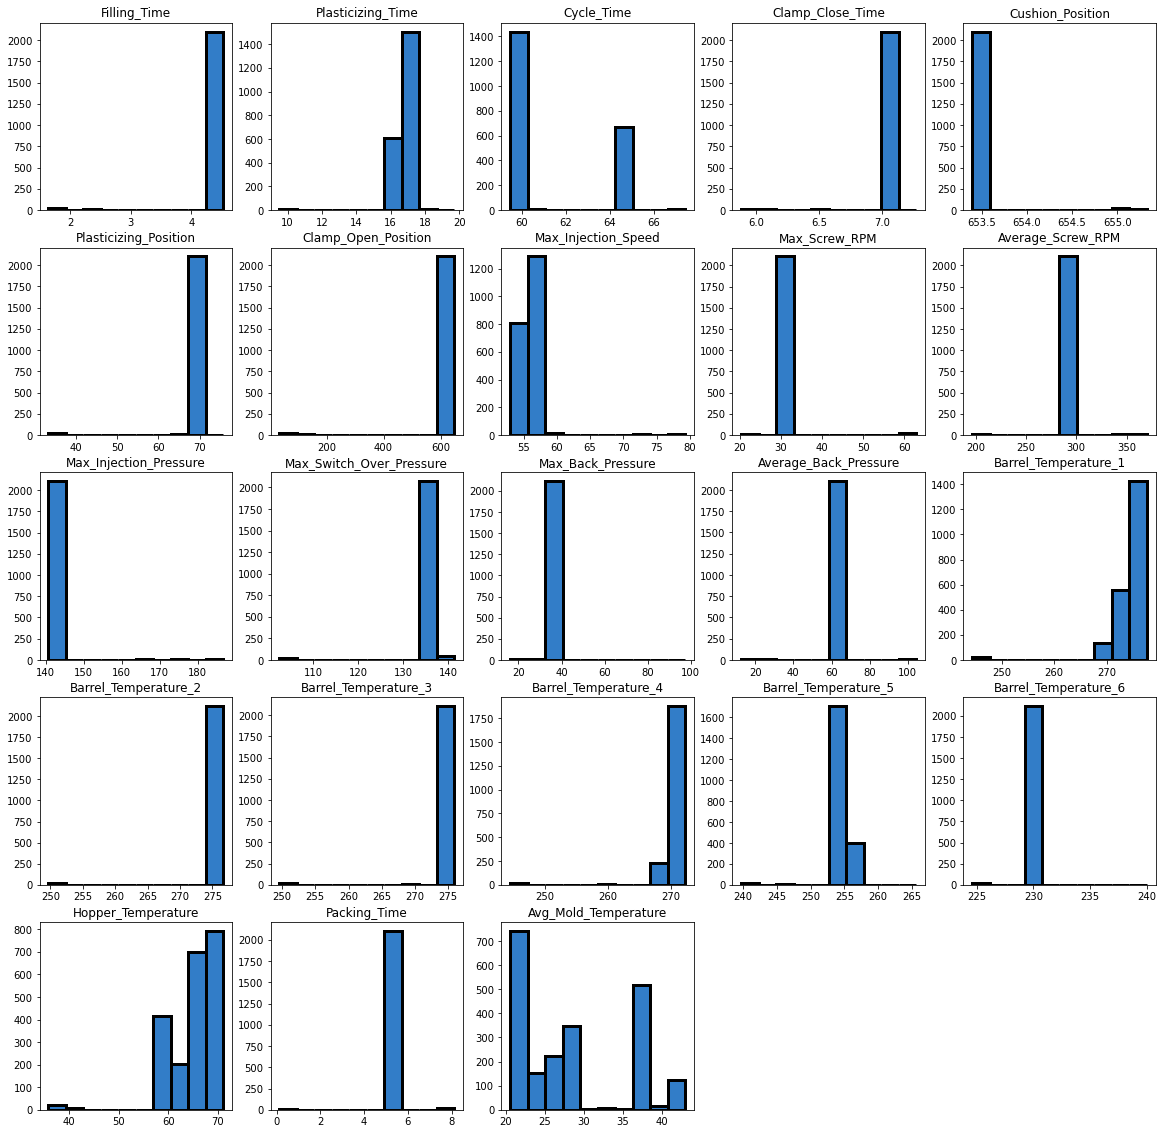

In [12]:
# unlabele데이터 히스토그램 시각화

data = unlabeled_CN7_650T_train
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

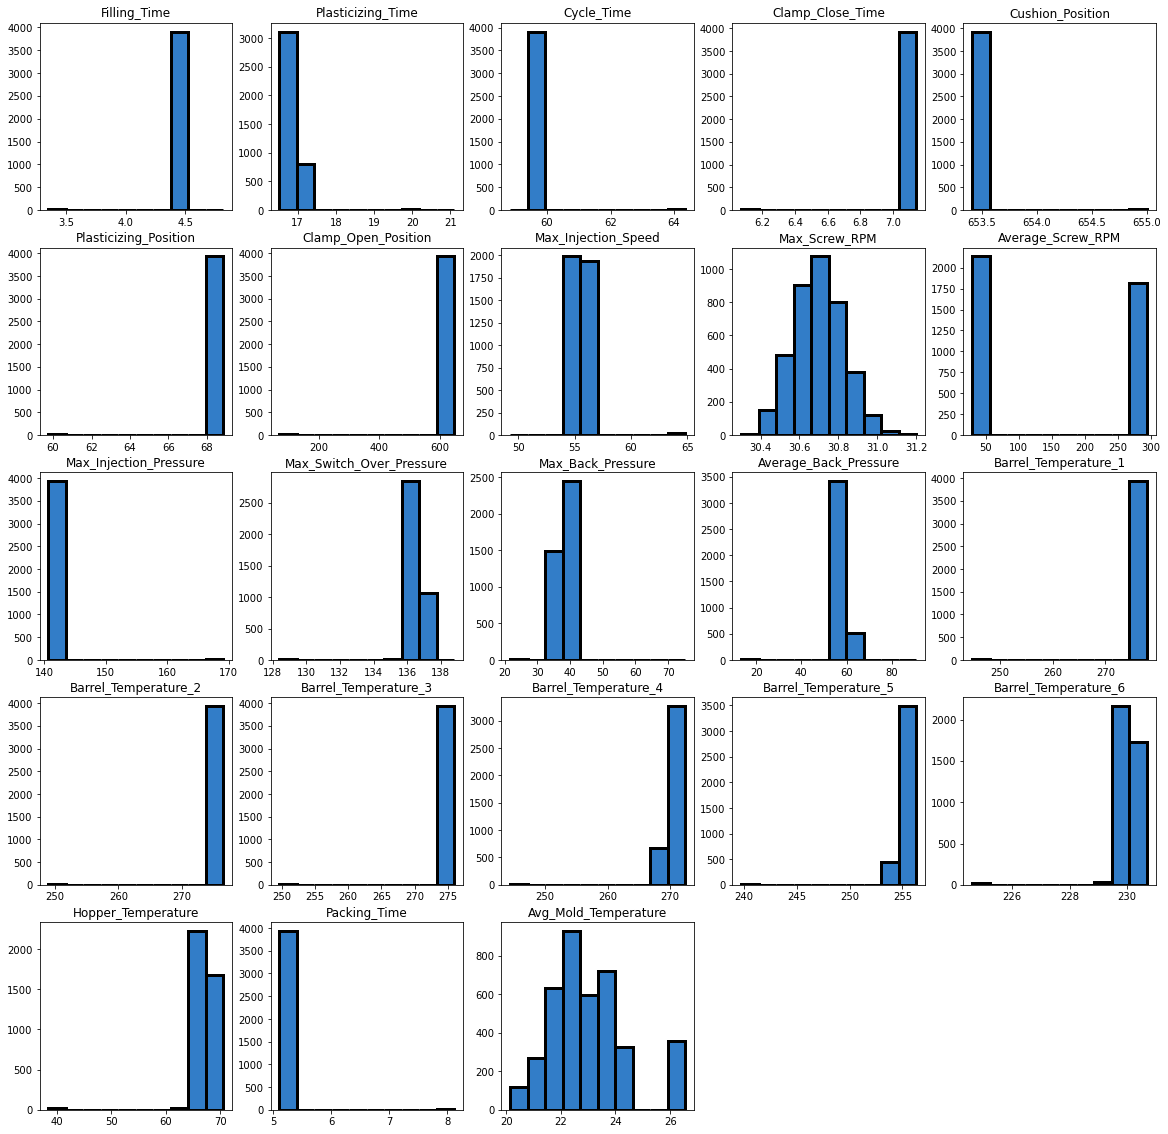

In [13]:
# labele데이터 히스토그램 시각화

data = labeled_df_Y
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

# DAE 적용

In [32]:
# label+unlabeled train 데이터
train_df = pd.concat([unlabeled_CN7_650T_train, labeled_df_Y], ignore_index=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6081 entries, 0 to 6080
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              6081 non-null   float64
 1   Plasticizing_Time         6081 non-null   float64
 2   Cycle_Time                6081 non-null   float64
 3   Clamp_Close_Time          6081 non-null   float64
 4   Cushion_Position          6081 non-null   float64
 5   Plasticizing_Position     6081 non-null   float64
 6   Clamp_Open_Position       6081 non-null   float64
 7   Max_Injection_Speed       6081 non-null   float64
 8   Max_Screw_RPM             6081 non-null   float64
 9   Average_Screw_RPM         6081 non-null   float64
 10  Max_Injection_Pressure    6081 non-null   float64
 11  Max_Switch_Over_Pressure  6081 non-null   float64
 12  Max_Back_Pressure         6081 non-null   float64
 13  Average_Back_Pressure     6081 non-null   float64
 14  Barrel_T

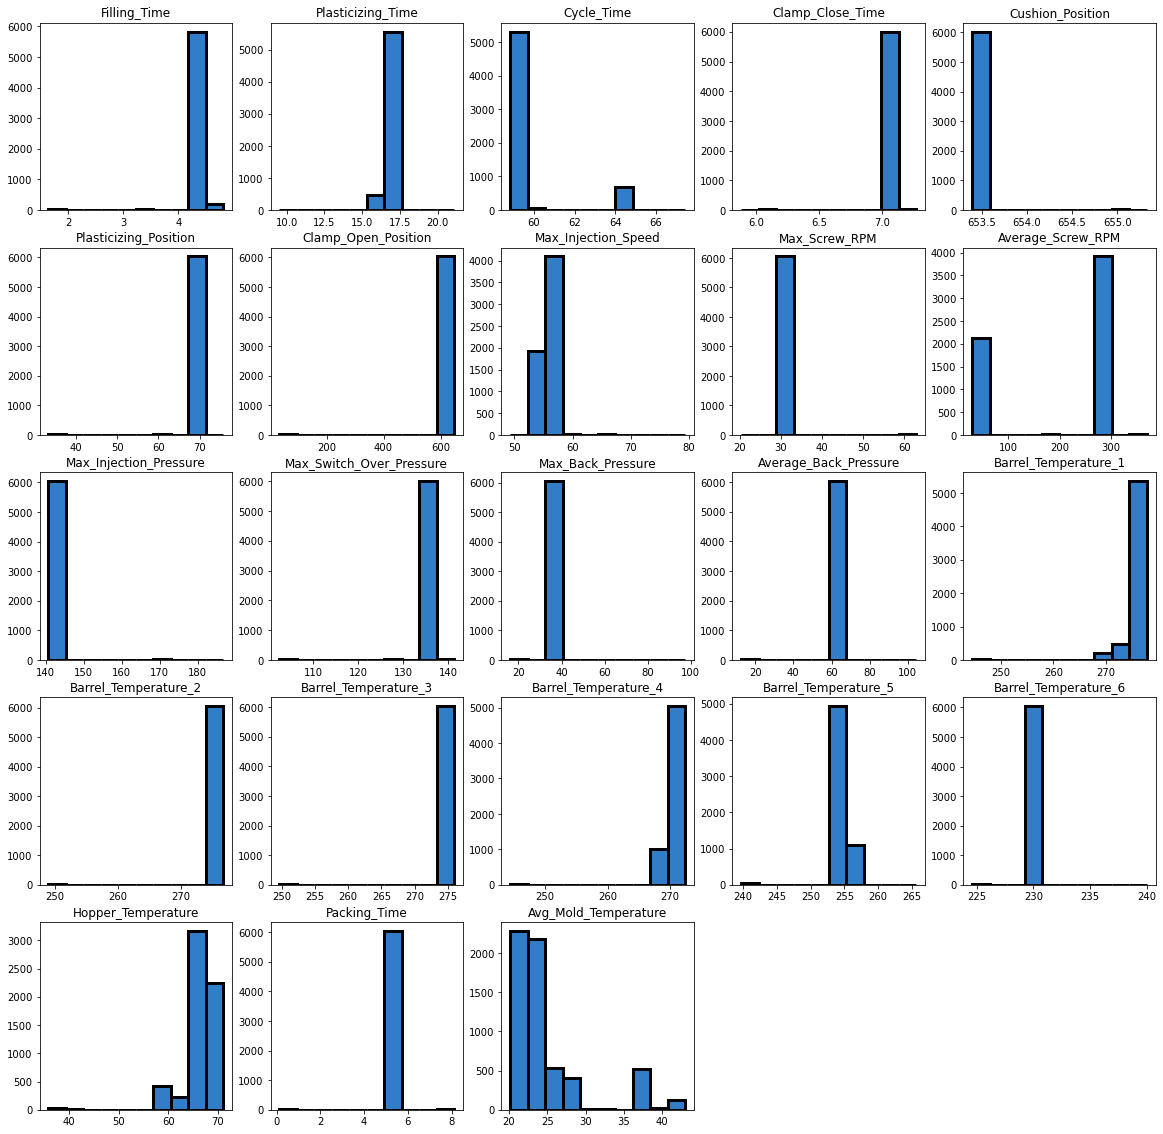

In [15]:
# train 데이터 히스토그램 시각화

data = train_df
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

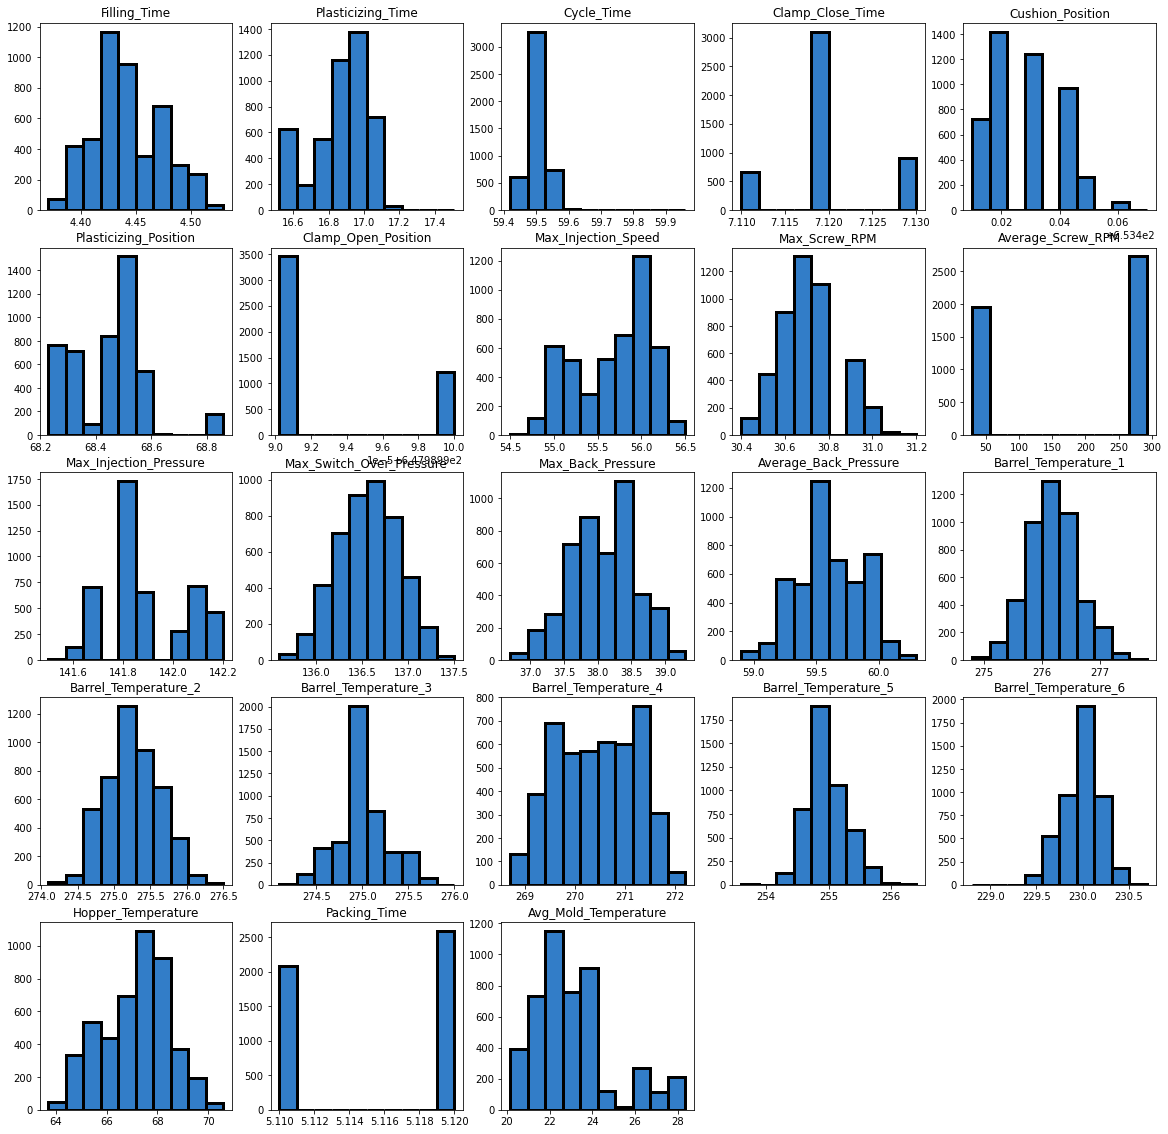

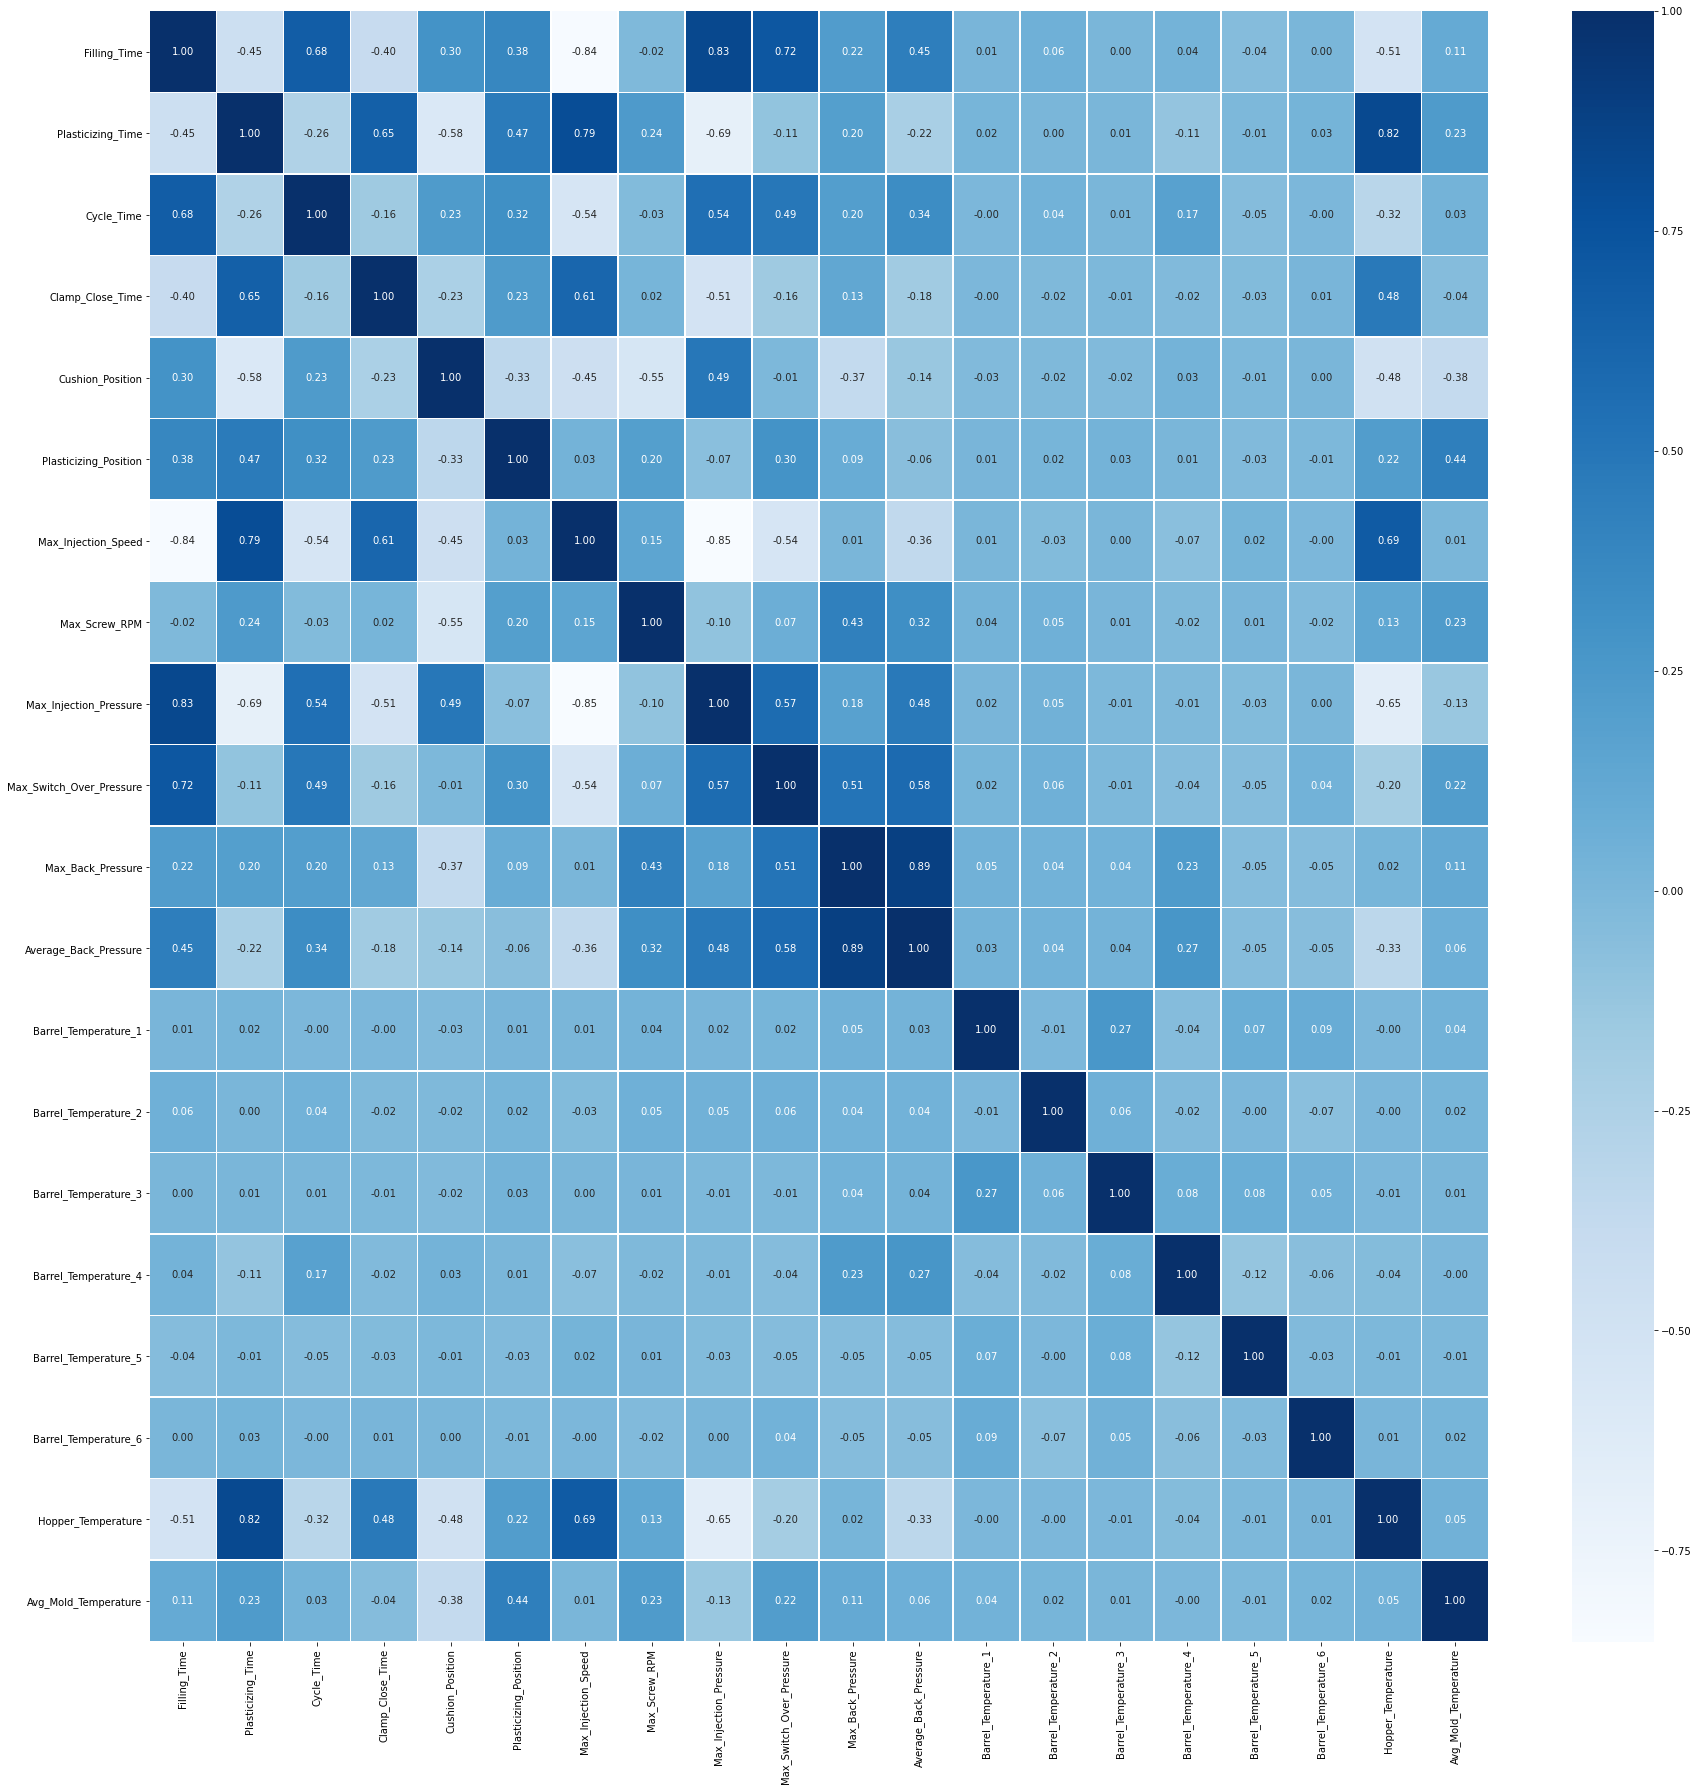

In [34]:
# outlier 제거
outlier_result = train_df.apply(outlier)
train_df = train_df[outlier_result.sum(axis=1) < 2]

data = train_df
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)
    
data = data.drop(["Clamp_Open_Position", "Average_Screw_RPM", "Packing_Time"], axis=1) 

# 상관관계 시각화
plt.figure(figsize=(30, 30))
sns.heatmap(data=data.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# 데이터 정규화
scaler = preprocessing.MinMaxScaler()
train_df = scaler.fit_transform(train_df)
labeled_df_N_test = scaler.transform(labeled_df_N_test)

# 학습, 평가데이터 분리
train_df, test_df_Y = train_test_split(train_df, train_size=0.8, test_size=0.2)

In [38]:
def denoising_autoencoder(data):
    data_input = Input((data.shape[1],))
    denoising = Dropout(0.3)(data_input)
    h1 = Dense(20)(data_input)
#     h1 = BatchNormalization()(h1)
    h1 = Activation('relu')(h1)
    h2 = Dense(10)(h1)
#     h2 = BatchNormalization()(h2)
    h2 = Activation('relu')(h2)
    h3 = Dense(5)(h2)
#     h3 = BatchNormalization()(h3)
    h3 = Activation('relu')(h3)
    h4 = Dense(10)(h3)
#     h4 = BatchNormalization()(h4)
    h4 = Activation('relu')(h4)
    h5 = Dense(20)(h4)
#     h5 = BatchNormalization()(h5)
    h5 = Activation('relu')(h5)
    h6 = Dense(data.shape[1])(h5)
#     h6 = BatchNormalization()(h6)
    out_put = Activation('relu')(h6)
    
    DAE = Model(data_input, out_put)
    DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    DAE.summary()
    return DAE
#     # Encoder
#     dropout_encoder = Sequential([Dropout(0.3), Dense(10, activation="relu"), Dense(5, activation="relu"), Dense(3, activation="relu")])
#     # Decoder
#     dropout_decoder = Sequential([Dense(5, activation="relu", input_shape=[3]), Dense(10, activation="relu", input_shape=[5]), Dense(data.shape[1], activation="relu")])
#     DAE = Sequential([dropout_encoder, dropout_decoder])
#     DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#     return DAE

In [39]:
# DAE 적용
DAE = denoising_autoencoder(train_df)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                480       
_________________________________________________________________
activation_12 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
activation_13 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 55        
_________________________________________________________________
activation_14 (Activation)   (None, 5)                 0   

In [40]:
# 모델 훈련
history = DAE.fit(train_df, train_df, batch_size=10, epochs=1000, validation_split=0.2, callbacks=[EarlyStopping(monitor="val_loss", patience=7, mode="min")])

Epoch 1/1000
299/299 [==============================] - 1s 2ms/step - loss: 0.1726 - accuracy: 0.0920 - val_loss: 0.1312 - val_accuracy: 0.0508
Epoch 2/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.1232 - accuracy: 0.0529 - val_loss: 0.1208 - val_accuracy: 0.0227
Epoch 3/1000
299/299 [==============================] - 0s 1ms/step - loss: 0.1181 - accuracy: 0.0994 - val_loss: 0.1171 - val_accuracy: 0.1283
Epoch 4/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.1145 - accuracy: 0.1278 - val_loss: 0.1134 - val_accuracy: 0.1511
Epoch 5/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.1110 - accuracy: 0.1590 - val_loss: 0.1104 - val_accuracy: 0.1791
Epoch 6/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.1086 - accuracy: 0.1978 - val_loss: 0.1084 - val_accuracy: 0.2059
Epoch 7/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.1069 - accuracy: 0.2972 - val_loss: 0.1070 - val_accuracy:

299/299 [==============================] - 0s 2ms/step - loss: 0.0814 - accuracy: 0.4183 - val_loss: 0.0820 - val_accuracy: 0.4211
Epoch 58/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0814 - accuracy: 0.4183 - val_loss: 0.0819 - val_accuracy: 0.4265
Epoch 59/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0813 - accuracy: 0.4227 - val_loss: 0.0819 - val_accuracy: 0.4198
Epoch 60/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0813 - accuracy: 0.4237 - val_loss: 0.0818 - val_accuracy: 0.4251
Epoch 61/1000
299/299 [==============================] - 1s 2ms/step - loss: 0.0813 - accuracy: 0.4237 - val_loss: 0.0818 - val_accuracy: 0.4251
Epoch 62/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.4264 - val_loss: 0.0818 - val_accuracy: 0.4198
Epoch 63/1000
299/299 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.4287 - val_loss: 0.0817 - val_accuracy: 0.4144

299/299 [==============================] - 0s 2ms/step - loss: 0.0772 - accuracy: 0.4950 - val_loss: 0.0776 - val_accuracy: 0.4786
Epoch 114/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0771 - accuracy: 0.4970 - val_loss: 0.0776 - val_accuracy: 0.4786
Epoch 115/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0771 - accuracy: 0.4967 - val_loss: 0.0776 - val_accuracy: 0.4840
Epoch 116/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.4983 - val_loss: 0.0775 - val_accuracy: 0.4826
Epoch 117/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.5027 - val_loss: 0.0774 - val_accuracy: 0.4799
Epoch 118/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0769 - accuracy: 0.4983 - val_loss: 0.0774 - val_accuracy: 0.4813
Epoch 119/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0769 - accuracy: 0.5013 - val_loss: 0.0773 - val_accuracy: 

Epoch 169/1000
299/299 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.3782 - val_loss: 0.0532 - val_accuracy: 0.3797
Epoch 170/1000
299/299 [==============================] - 0s 1ms/step - loss: 0.0523 - accuracy: 0.3778 - val_loss: 0.0531 - val_accuracy: 0.3890
Epoch 171/1000
299/299 [==============================] - 0s 1ms/step - loss: 0.0522 - accuracy: 0.3795 - val_loss: 0.0530 - val_accuracy: 0.3463
Epoch 172/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0521 - accuracy: 0.3688 - val_loss: 0.0528 - val_accuracy: 0.3997
Epoch 173/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0520 - accuracy: 0.3782 - val_loss: 0.0527 - val_accuracy: 0.3984
Epoch 174/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0519 - accuracy: 0.3758 - val_loss: 0.0527 - val_accuracy: 0.3690
Epoch 175/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0518 - accuracy: 0.3768 - val_loss: 0.0525 -

299/299 [==============================] - 0s 1ms/step - loss: 0.0501 - accuracy: 0.3993 - val_loss: 0.0510 - val_accuracy: 0.4158
Epoch 226/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.3959 - val_loss: 0.0509 - val_accuracy: 0.4385
Epoch 227/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.3983 - val_loss: 0.0509 - val_accuracy: 0.4225
Epoch 228/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.4009 - val_loss: 0.0509 - val_accuracy: 0.4051
Epoch 229/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.3949 - val_loss: 0.0509 - val_accuracy: 0.4318
Epoch 230/1000
299/299 [==============================] - 0s 1ms/step - loss: 0.0500 - accuracy: 0.3986 - val_loss: 0.0509 - val_accuracy: 0.4572
Epoch 231/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.4013 - val_loss: 0.0509 - val_accuracy: 

Epoch 281/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.4016 - val_loss: 0.0505 - val_accuracy: 0.4225
Epoch 282/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.4029 - val_loss: 0.0505 - val_accuracy: 0.4158
Epoch 283/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.3996 - val_loss: 0.0505 - val_accuracy: 0.3971
Epoch 284/1000
299/299 [==============================] - 0s 1ms/step - loss: 0.0496 - accuracy: 0.3969 - val_loss: 0.0505 - val_accuracy: 0.4479
Epoch 285/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.3993 - val_loss: 0.0505 - val_accuracy: 0.4184
Epoch 286/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.3976 - val_loss: 0.0505 - val_accuracy: 0.4465
Epoch 287/1000
299/299 [==============================] - 0s 2ms/step - loss: 0.0496 - accuracy: 0.3996 - val_loss: 0.0505 -

In [41]:
# 훈련격과 시각화 함수
def training_visualize(model_his):
    sub = plt.subplot(2, 1, 1)
    # 훈련 결과 시각화
    sub.plot(model_his.history["loss"], label="Training Loss")
    sub.plot(model_his.history["val_loss"], label="Validation Loss")
    sub.legend()
    sub = plt.subplot(2, 1, 2)
    sub.plot(model_his.history["accuracy"], label="Training Acc")
    sub.plot(model_his.history["val_accuracy"], label="Validation Acc")
    sub.legend()

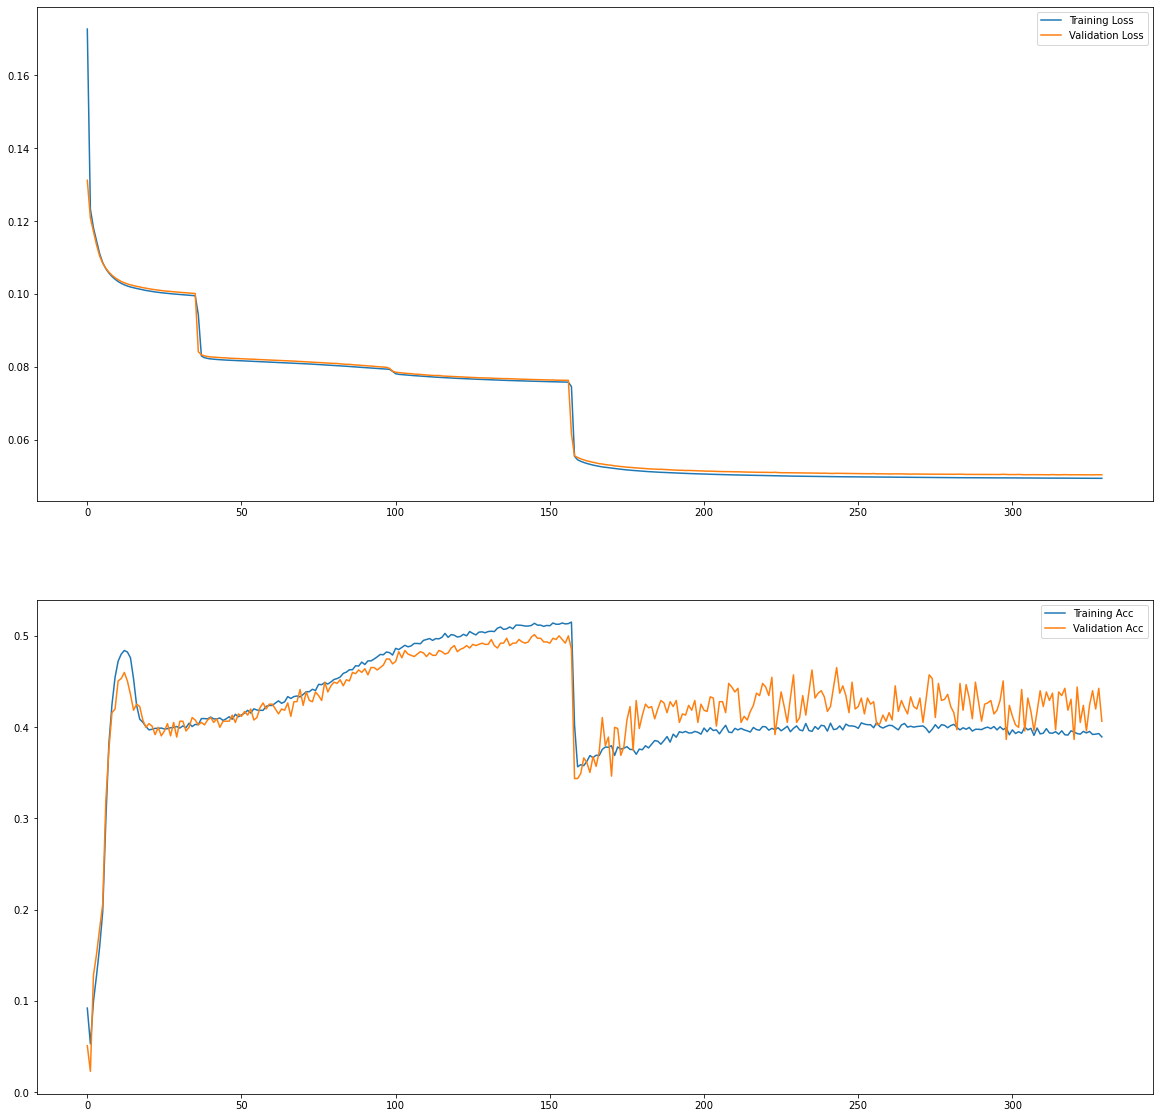

In [42]:
# 데이터 별 훈련결과 시각화
training_visualize(history)

In [43]:
def defective_decision(DAE, train_data, test_data):
    # 학습 데이터 예측값
    pred = DAE.predict(train_data)
    # 학습 데이터 복원 오차
    train_loss = np.mean(np.square(pred-train_data), axis=1)
    #임계치 (3시그마-99.7%)
    threshold = np.mean(train_loss) + 3*np.std(train_loss)

    # 평가 데이터
    # 예측값
    pred_def = DAE.predict(test_data)
    # 복원오차
    test_loss = np.mean(np.square(pred_def - test_data), axis=1)
    
    # colunm별 절대 오차
    colunm_error = np.abs(pred_def - test_data)

    defect = test_loss > threshold
    print("불량 개수: ", np.sum(defect))
    
    return defect, colunm_error

In [44]:
# 확인
print(f"테스트 데이터 개수: {len(test_df_Y)}")
test_Y_defect, Y_CE = defective_decision(DAE, train_df, test_df_Y)

테스트 데이터 개수: 935
불량 개수:  0


In [45]:
# 확인
print(f"테스트 데이터 개수: {len(labeled_df_N_test)}")
test_N_defect, N_CE = defective_decision(DAE, train_df, labeled_df_N_test)

테스트 데이터 개수: 28
불량 개수:  28


In [46]:
true_val = np.concatenate([np.zeros(len(test_Y_defect)), np.ones(len(test_N_defect))])
predict_val = np.concatenate([test_Y_defect, test_N_defect])

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
confusion_matrix(true_val, predict_val)

array([[935,   0],
       [  0,  28]], dtype=int64)

In [48]:
print("정확도: ", accuracy_score(true_val, predict_val))
print("정밀도: ", precision_score(true_val, predict_val))
print("재현율: ", recall_score(true_val, predict_val))
print("F1: ", f1_score(true_val, predict_val))

정확도:  1.0
정밀도:  1.0
재현율:  1.0
F1:  1.0


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
(latent_vector 시각화)

encoder = Model(inputs = input_img, outputs=encoder2)

latent_vector = encoder.predict(x_test)

rcParams['figure.figsize'] = 10, 8
fig = plt.figure(1)
ax = Axes3D(fig)

xs = latent_vector[:, 0]
ys = latent_vector[:, 1]
zs = latent_vector[:, 2]

color = ['red', 'green', 'blue', 'lime', 'white', 'pink', 'aqua', 'violet', 'gold', 'coral']

for x, y, z, label in zip(xs, ys, zs, y_test):
  c=color[int(label)]
  ax.text(x,y,z,label, backgroundcolor=c)

ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())
ax.set_zlim(zs.min(), zs.max())

plt.show()

In [28]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter]
CN7_650T_1st_refine = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME"], axis=1)
# 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
CN7_650T_1st_refine = CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] <= 0]
# CN7_650T_1st_refine.drop("ERR_FACT_QTY", axis=1, inplace=True)
# 학습을 위해 Time데이터 제거
CN7_650T_1st_refine.drop("TimeStamp", axis=1, inplace=True)

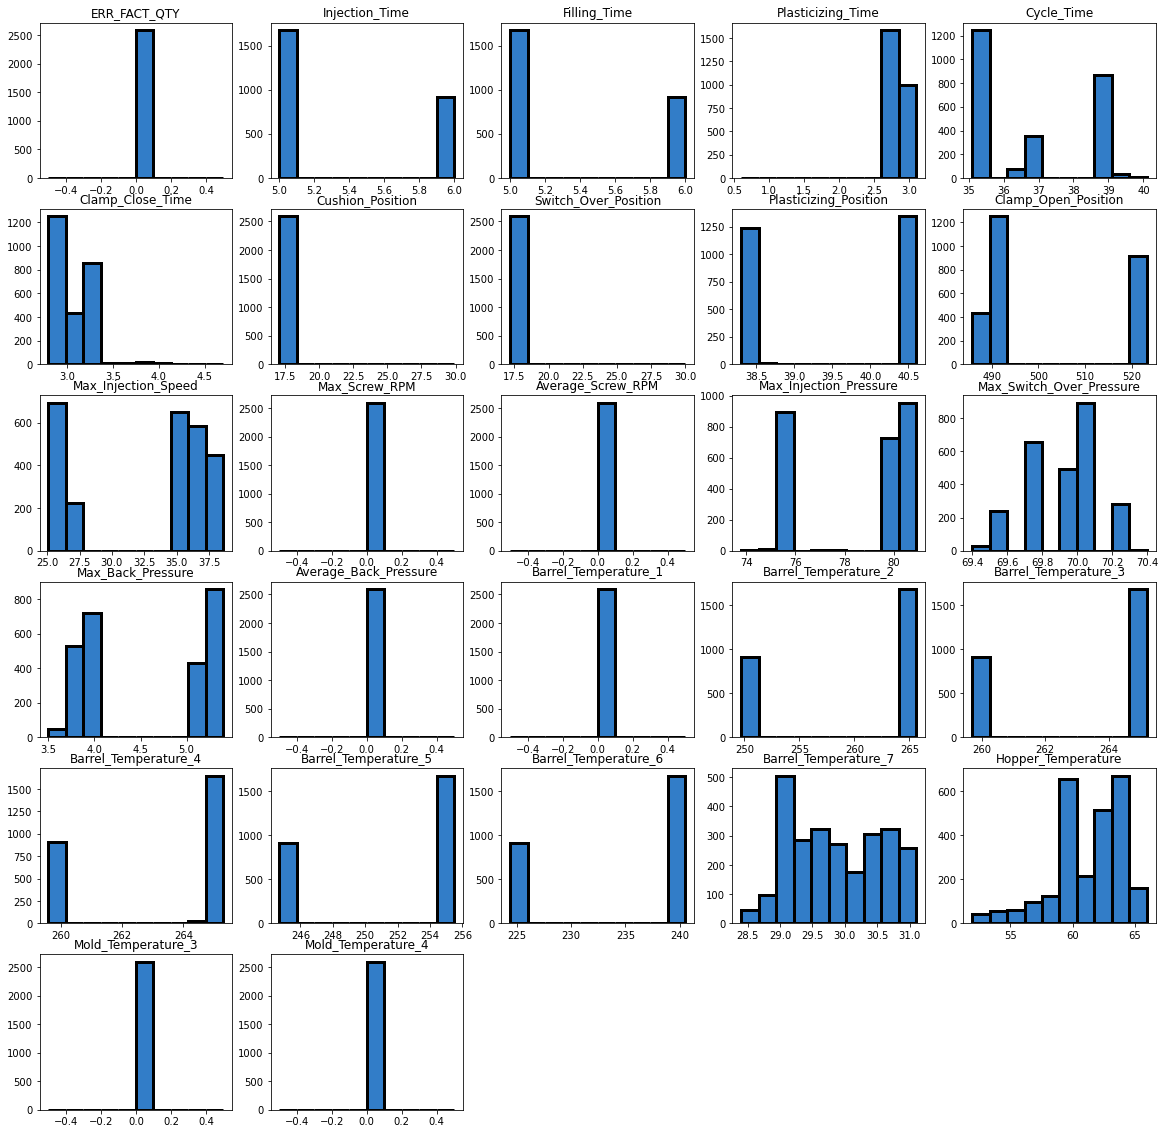

In [29]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] != 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

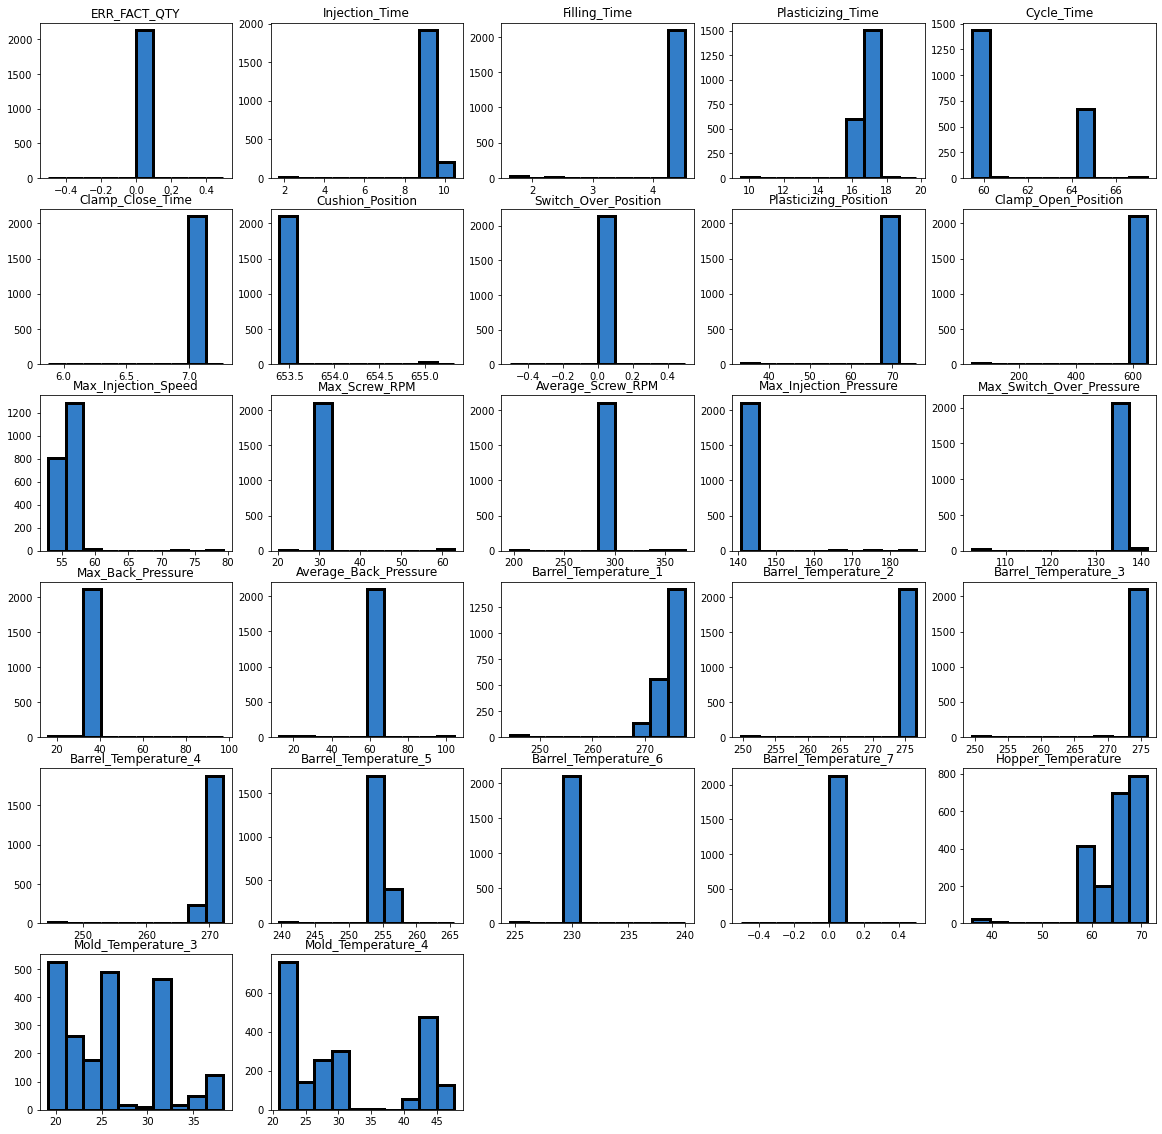

In [30]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

In [31]:
# 히스토그램 시각화
# test_df - 나누기 전

data = test_df[test_df["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

NameError: name 'test_df' is not defined

In [ ]:
# 상관관계 시각화
plt.figure(figsize=(30, 30))
sns.heatmap(data=CN7_650T_1st_refine[CN7_650T_1st_refine["PART_TYPE"].isin([1])].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# 히스토그램 시각화
visual_CN7_650T_1st_refine = CN7_650T_1st_refine.drop("TimeStamp", axis=1)
for index, value in enumerate(visual_CN7_650T_1st_refine):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(visual_CN7_650T_1st_refine[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)